In [65]:
!pip install git+https://github.com/openai/CLIP.git 

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-iyv6ieik
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-iyv6ieik
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=9b71293d80b4888dc6359dc902125db88d8a4f8b2e81f401f1dda2594787e150
  Stored in directory: /tmp/pip-ephem-wheel-cache-jrn8h8m3/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [113]:
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import torch
from collections import Counter
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import clip

# Utils

In [114]:
def find_most_common_answer(answers):
    answer_counter = Counter(answers)
    most_common_answers = answer_counter.most_common()
    most_common_answer, count = most_common_answers[0]
    return most_common_answer

def select_most_common_answers(df):
    selected_answers = []
    for idx, row in df.iterrows():
        answers = [answer["answer"] for answer in row["answers"]]
        selected_answer = find_most_common_answer(answers)
        
        selected_answers.append({
            "answer": selected_answer
        })

    # Update the "answer" and "answer_confidence" columns in the DataFrame
    df[["answer"]] = pd.DataFrame(selected_answers)
    
    return df.drop(["answers"], axis=1)

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def plot_img(path):
    # Load the JPEG image
    image = mpimg.imread(path)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()

In [3]:
def dataloader_json(path,test=False):
    # Load the JSON file
    with open(path, 'r') as f:
        data = json.load(f)
    # Create a DataFrame from the loaded JSON data
    df = pd.DataFrame(data)
    
    if test:
        return df
    
    return select_most_common_answers(df)

# Data Loading

In [4]:
train_df = dataloader_json("/kaggle/input/d/lhanhsin/vizwiz/Annotations/Annotations/train.json")

train_df

image  \
0      VizWiz_train_00000000.jpg   
1      VizWiz_train_00000001.jpg   
2      VizWiz_train_00000002.jpg   
3      VizWiz_train_00000003.jpg   
4      VizWiz_train_00000004.jpg   
...                          ...   
20518  VizWiz_train_00023949.jpg   
20519  VizWiz_train_00023950.jpg   
20520  VizWiz_train_00023951.jpg   
20521  VizWiz_train_00023952.jpg   
20522  VizWiz_train_00023953.jpg   

                                                question   answer_type  \
0                       What's the name of this product?         other   
1            Can you tell me what is in this can please?         other   
2      Is this enchilada sauce or is this tomatoes?  ...         other   
3                What is the captcha on this screenshot?         other   
4                                     What is this item?         other   
...                                                  ...           ...   
20518                  What's the color for this laptop?         other   
20519  (inaudible) can you see it? If so, then tell m...         other   
20520         What are the three numbers I have to type?  unanswerable   
20521                                       Is it a box?        yes/no   
20522                      What is this in this picture?         other   

       answerable              answer  
0               1        basil leaves  
1               1           coca cola  
2               1            tomatoes  
3               1                t36m  
4               1  solar garden light  
...           ...                 ...  
20518           1               black  
20519           1        unanswerable  
20520           0    unsuitable image  
20521           1                  no  
20522           1                 car  

[20523 rows x 5 columns]

In [6]:
train_df['answer'].value_counts()

unanswerable                               3941
unsuitable                                 3038
no                                          567
yes                                         516
white                                       298
                                           ... 
jenny craig florentine breakfast pizzas       1
heads                                         1
sunny paris seasoning                         1
bat                                           1
ipseuri new                                   1
Name: answer, Length: 5630, dtype: int64

In [7]:
val_df = dataloader_json("/kaggle/input/d/lhanhsin/vizwiz/Annotations/Annotations/val.json")

val_df

image  \
0     VizWiz_val_00000000.jpg   
1     VizWiz_val_00000001.jpg   
2     VizWiz_val_00000002.jpg   
3     VizWiz_val_00000003.jpg   
4     VizWiz_val_00000004.jpg   
...                       ...   
4314  VizWiz_val_00004314.jpg   
4315  VizWiz_val_00004315.jpg   
4316  VizWiz_val_00004316.jpg   
4317  VizWiz_val_00004317.jpg   
4318  VizWiz_val_00004318.jpg   

                                               question   answer_type  \
0     Ok. There is another picture I hope it is a be...  unanswerable   
1         Can you tell me what this medicine is please?         other   
2                      What is the title of this book?          other   
3                            Which one is the blue one?         other   
4                              What does the arrow say?  unanswerable   
...                                                 ...           ...   
4314                                      what is this?         other   
4315                                    Is this modern?  unanswerable   
4316  I need to buy this battery for my cordless pho...  unanswerable   
4317                          What kind of mix is this?         other   
4318                        What kind of spice is this?         other   

      answerable          answer  
0              0    unanswerable  
1              1      night time  
2              1       dog years  
3              1           right  
4              0    unanswerable  
...          ...             ...  
4314           1  salad dressing  
4315           0      unsuitable  
4316           0    unanswerable  
4317           1            cake  
4318           1    garam masala  

[4319 rows x 5 columns]

In [8]:
val_df['answer'].nunique()

1531

In [9]:
data_df = pd.concat((train_df,val_df), axis =0,ignore_index=True)
data_df

image  \
0      VizWiz_train_00000000.jpg   
1      VizWiz_train_00000001.jpg   
2      VizWiz_train_00000002.jpg   
3      VizWiz_train_00000003.jpg   
4      VizWiz_train_00000004.jpg   
...                          ...   
24837    VizWiz_val_00004314.jpg   
24838    VizWiz_val_00004315.jpg   
24839    VizWiz_val_00004316.jpg   
24840    VizWiz_val_00004317.jpg   
24841    VizWiz_val_00004318.jpg   

                                                question   answer_type  \
0                       What's the name of this product?         other   
1            Can you tell me what is in this can please?         other   
2      Is this enchilada sauce or is this tomatoes?  ...         other   
3                What is the captcha on this screenshot?         other   
4                                     What is this item?         other   
...                                                  ...           ...   
24837                                      what is this?         other   
24838                                    Is this modern?  unanswerable   
24839  I need to buy this battery for my cordless pho...  unanswerable   
24840                          What kind of mix is this?         other   
24841                        What kind of spice is this?         other   

       answerable              answer  
0               1        basil leaves  
1               1           coca cola  
2               1            tomatoes  
3               1                t36m  
4               1  solar garden light  
...           ...                 ...  
24837           1      salad dressing  
24838           0          unsuitable  
24839           0        unanswerable  
24840           1                cake  
24841           1        garam masala  

[24842 rows x 5 columns]

## Label Encoding

In [10]:
ans_lb = LabelEncoder()
data_df['answer'] = ans_lb.fit_transform(data_df['answer'])
ans_type_lb = LabelEncoder()
data_df['answer_type']= ans_type_lb.fit_transform(data_df['answer_type'])

In [11]:
data_df

image  \
0      VizWiz_train_00000000.jpg   
1      VizWiz_train_00000001.jpg   
2      VizWiz_train_00000002.jpg   
3      VizWiz_train_00000003.jpg   
4      VizWiz_train_00000004.jpg   
...                          ...   
24837    VizWiz_val_00004314.jpg   
24838    VizWiz_val_00004315.jpg   
24839    VizWiz_val_00004316.jpg   
24840    VizWiz_val_00004317.jpg   
24841    VizWiz_val_00004318.jpg   

                                                question  answer_type  \
0                       What's the name of this product?            1   
1            Can you tell me what is in this can please?            1   
2      Is this enchilada sauce or is this tomatoes?  ...            1   
3                What is the captcha on this screenshot?            1   
4                                     What is this item?            1   
...                                                  ...          ...   
24837                                      what is this?            1   
24838                                    Is this modern?            2   
24839  I need to buy this battery for my cordless pho...            2   
24840                          What kind of mix is this?            1   
24841                        What kind of spice is this?            1   

       answerable  answer  
0               1     768  
1               1    1727  
2               1    5885  
3               1    5694  
4               1    5378  
...           ...     ...  
24837           1    5058  
24838           0    6042  
24839           0    6033  
24840           1    1269  
24841           1    2702  

[24842 rows x 5 columns]

In [12]:
val = data_df.iloc[20523:].reset_index(drop=True)
val

image  \
0     VizWiz_val_00000000.jpg   
1     VizWiz_val_00000001.jpg   
2     VizWiz_val_00000002.jpg   
3     VizWiz_val_00000003.jpg   
4     VizWiz_val_00000004.jpg   
...                       ...   
4314  VizWiz_val_00004314.jpg   
4315  VizWiz_val_00004315.jpg   
4316  VizWiz_val_00004316.jpg   
4317  VizWiz_val_00004317.jpg   
4318  VizWiz_val_00004318.jpg   

                                               question  answer_type  \
0     Ok. There is another picture I hope it is a be...            2   
1         Can you tell me what this medicine is please?            1   
2                      What is the title of this book?             1   
3                            Which one is the blue one?            1   
4                              What does the arrow say?            2   
...                                                 ...          ...   
4314                                      what is this?            1   
4315                                    Is this modern?            2   
4316  I need to buy this battery for my cordless pho...            2   
4317                          What kind of mix is this?            1   
4318                        What kind of spice is this?            1   

      answerable  answer  
0              0    6033  
1              1    4135  
2              1    2220  
3              1    4962  
4              0    6033  
...          ...     ...  
4314           1    5058  
4315           0    6042  
4316           0    6033  
4317           1    1269  
4318           1    2702  

[4319 rows x 5 columns]

# Clip Encoding

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-L/14", device=device)

print(f'Using {device}')

Using cuda


In [ ]:
encodings = []
for img , question in tqdm(zip(train_df['image'],train_df['question'])):
    if "train" in img:
        image = preprocess(Image.open(f'/kaggle/input/d/lhanhsin/vizwiz/train/train/{img}').rotate(90)).unsqueeze(0).to(device)
    elif "test" in img:
        image = preprocess(Image.open(f'/kaggle/input/d/lhanhsin/vizwiz/test/test/{img}')).unsqueeze(0).to(device)
    else:
        image = preprocess(Image.open(f'/kaggle/input/d/lhanhsin/vizwiz/val/val/{img}')).unsqueeze(0).to(device)

    text = clip.tokenize(question).to(device)

    with torch.no_grad():
        image_encoding = model_clip.encode_image(image)
        text_encoding = model_clip.encode_text(text)
    
    encodings.append(torch.cat([image_encoding, text_encoding], dim=-1))

In [25]:
torch.save(encodings,"encd768-90.pt")

# Train Test Split

In [14]:
# Generate the indices for train-test split
indices = np.arange(20523)

# Perform train-test split
train_indices, test_indices = train_test_split(indices, test_size=0.05, random_state=42, stratify=data_df.iloc[:20523]['answer_type'])

In [15]:
train_indices_aug = train_indices + 20523

In [16]:
train = data_df.iloc[train_indices] 
train = train.reset_index(drop=True)
train

image  \
0      VizWiz_train_00014709.jpg   
1      VizWiz_train_00009566.jpg   
2      VizWiz_train_00011322.jpg   
3      VizWiz_train_00005267.jpg   
4      VizWiz_train_00009281.jpg   
...                          ...   
19491  VizWiz_train_00015453.jpg   
19492  VizWiz_train_00019967.jpg   
19493  VizWiz_train_00017226.jpg   
19494  VizWiz_train_00016495.jpg   
19495  VizWiz_train_00008401.jpg   

                                                question  answer_type  \
0                                          What is this?            1   
1      What product is this? Is it moisturizing lotion?             1   
2                                    What's in this box?            2   
3                What is in this kitchen?  In this room?            1   
4                       Is this shampoo or conditioner?             1   
...                                                  ...          ...   
19491                              What number is shown?            0   
19492                                        Where is B?            1   
19493                          What kind of tea is this?            1   
19494                                      What is this?            1   
19495                                Whats in the water?            1   

       answerable  answer  
0               1    5923  
1               1    6453  
2               0    6033  
3               1    2536  
4               1    5186  
...           ...     ...  
19491           1     233  
19492           1    3658  
19493           1    4276  
19494           1    1650  
19495           1    4193  

[19496 rows x 5 columns]

In [17]:
test = data_df.iloc[test_indices]
test = test.reset_index(drop=True)
test

image  \
0     VizWiz_train_00023579.jpg   
1     VizWiz_train_00001384.jpg   
2     VizWiz_train_00015850.jpg   
3     VizWiz_train_00010122.jpg   
4     VizWiz_train_00016891.jpg   
...                         ...   
1022  VizWiz_train_00010922.jpg   
1023  VizWiz_train_00017572.jpg   
1024  VizWiz_train_00016464.jpg   
1025  VizWiz_train_00001537.jpg   
1026  VizWiz_train_00005393.jpg   

                                               question  answer_type  \
0     Sometimes they're able to and sometimes they a...            2   
1             What is the title of this book? Thank you            2   
2                                   What color is this?            1   
3                  What's being displayed on my screen?            1   
4                                    What is this item?            1   
...                                                 ...          ...   
1022                   What flavor of kool aid is this?            1   
1023                                 What is this item?            1   
1024          What is the name of this book? Thank you.            1   
1025                                      What is this?            1   
1026                    What does this cover sheet say?            2   

      answerable  answer  
0              0    6033  
1              0    6033  
2              1    4565  
3              1     402  
4              1    2906  
...          ...     ...  
1022           1    5977  
1023           1    4891  
1024           1    3639  
1025           1    6362  
1026           0    6042  

[1027 rows x 5 columns]

In [18]:
# Create a figure with six subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(18, 6))

# Plot histogram for 'answerable' with a different color
ax1.hist(pd.concat((train_df,val_df),axis = 0)['answerable'], bins=10, alpha=0.5, color='black', align='mid')
ax1.set_title('Histogram of Answerable')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

# Plot histogram for 'answer_type' with a different color
ax2.hist(pd.concat((train_df,val_df),axis = 0)['answer_type'], bins=10, alpha=0.5, color='red', align='mid')
ax2.set_title('Histogram of Answer Type')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')



fig.tight_layout()

# Display the plot
plt.show()


# Model

## Dimensions

In [34]:
embedding_size = 768
classes = len(np.unique(ans_lb.classes_))
aux_classes = len(np.unique(train['answer_type']))
BATCH_SIZE = 64

In [20]:
classes, aux_classes

(6503, 4)

## Encdoed data

In [21]:
encd = torch.cat([torch.load('/kaggle/input/encd21/encALL.pt')])

## Dataset Class and Dataloaders

In [53]:
class dataset(Dataset):
    def __init__(self, indices, answers, types, length):
        self.indices = indices
        self.answers = answers
        self.types = types
        self.length = length

    def __getitem__(self, index):
            if self.length <= 20523:
                return encd[self.indices[index]].float() , torch.tensor(int(self.answers[index])), torch.tensor(int(self.types[index]))
            
            return encd[self.indices[index]].float() , torch.tensor(int(self.answers[index % (self.length/2)])), torch.tensor(int(self.types[index % (self.length/2)]))
            
    def __len__(self):
          return self.length

In [54]:
trainDataset = dataset(np.concatenate((train_indices, train_indices_aug)), train['answer'], train['answer_type'], len(train_indices)*2)


valDataset = dataset(np.array(list(range(encd.shape[0] - 4319, encd.shape[0]))), val['answer'], val['answer_type'], 4319)

train_dataloader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=0)

val_dataloader = DataLoader(valDataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=0)

## Architecture

### According to authors choosen archtecture

In [88]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ln1 = nn.LayerNorm(embedding_size*2)
        self.dp1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embedding_size* 2, 512)
        
        self.ln2 = torch.nn.LayerNorm(512)
        self.dp2 = torch.nn.Dropout(0.5)
        
        self.fc2 = torch.nn.Linear(512, classes)
        
        self.fc_aux = torch.nn.Linear(512, aux_classes)
        
        self.lnaux = torch.nn.LayerNorm(aux_classes)
        self.dpaux = torch.nn.Dropout(0.5)
                
        self.fc_gate = torch.nn.Linear(aux_classes, classes)
        self.act_gate = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.ln1(x)
        x = self.dp1(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        x = self.ln2(x)
        x = self.dp2(x)
        
#         aux
        aux = self.fc_aux(x)
#         aux = self.lnaux(aux)
#         aux = self.dpaux(aux)
        
#         linear bottom
        vqa = self.fc2(x)
        
        output = vqa * self.act_gate(self.fc_gate(aux))
        
        
        return output,aux

## Training and Validation

In [89]:
def run_model(model,dataloader,val_loader, optimizer,train = True ):
    if train:
        model.train()
    
    loss = nn.CrossEntropyLoss()
    
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    total_correct_ty = 0
    total_samples_ty = 0
    
    for (data, ans , ans_type) in tqdm(dataloader):
        data = data.to(device)
        ans = ans.to(device)
        ans_type = ans_type.to(device)
        optimizer.zero_grad()
        output , aux = model(data)
        
        loss_ans = loss(output, ans)
        loss_type = loss(aux,ans_type)
        loss_combined=loss_ans+loss_type
        total_loss += loss_combined.item()
        loss_combined.backward()
        optimizer.step()
        
        
#         Answer Accurracy
        _, predicted_labels = torch.max(output, dim=1)
        correct = (predicted_labels == ans).sum().item()
        total_correct += correct
        total_samples += ans.size(0)
        train_accuracy = total_correct / total_samples
        
#         Type Accuracy
        _, predicted_labels_ty = torch.max(aux, dim=1)
        correct_ty = (predicted_labels_ty == ans_type).sum().item()
        total_correct_ty += correct_ty
        total_samples_ty += ans_type.size(0)
        train_accuracy_ty = total_correct_ty / total_samples_ty
    
    total_train_accuracy = (train_accuracy + train_accuracy_ty) / 2
        
        
    if val_loader is not None:
        model.eval()

    # Initialize validation-specific variables
    val_loss = 0.0
    total_correct_val=0
    total_samples_val=0
    
    total_correct_val_ty=0
    total_samples_val_ty=0
    
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation data
        for (data, ans , ans_type) in val_loader:
            data = data.to(device)
            ans = ans.to(device)
            ans_type = ans_type.to(device)
            
            # Forward pass
            output , aux = model(data)

            # Compute the loss
            loss_ans = loss(output, ans)
            loss_type = loss(aux,ans_type)
            loss_combined=loss_ans+loss_type
            val_loss += loss_combined.item()

            # Update validation metrics
            _, val_predicted = torch.max(output, dim=1)
            correct_val = (val_predicted == ans).sum().item()
            total_correct_val += correct_val
            total_samples_val += ans.size(0)
            val_accuracy = total_correct_val / total_samples_val
            
            _, val_predicted_ty = torch.max(aux, dim=1)
            correct_val_ty = (val_predicted_ty == ans_type).sum().item()
            total_correct_val_ty += correct_val_ty
            total_samples_val_ty += ans_type.size(0)
            val_accuracy_ty = total_correct_val_ty / total_samples_val_ty
        
        total_val_accuracy = (val_accuracy + val_accuracy_ty) / 2
        
    train_loss = total_loss/len(dataloader)
    val_loss = val_loss/len(val_loader)
    
    print(f"\nTrain Loss: {train_loss:.4f} | AVG Train ACC: {total_train_accuracy * 100:.4f}% | Val Loss: {val_loss:.4f} | AVG Val ACC: {total_val_accuracy * 100:.2f}%")
    
    print(f"\nTrain ANS ACC: {train_accuracy * 100:.4f}% | VAL ANS ACC: {val_accuracy * 100:.4f}% | Train TYPE ACC: {train_accuracy_ty * 100:.4f}% | VAL TYPE ACC: {val_accuracy_ty * 100:.2f}%\n")
        
    return train_loss, val_loss

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model()
model = model.to(device)
model = nn.DataParallel(model)

epoch = 125
training_loss = []
val_loss = []

optimizer = torch.optim.Adam(model.parameters(),1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.1, threshold=1e-6)

early_stopping_patience = 15  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

for e in range(epoch):
    print(f'Epoch: {e+1}', f'| LR: { optimizer.param_groups[0]["lr"] }')
    trLoss, vlLoss = run_model(model,train_dataloader,val_dataloader,optimizer)    
    training_loss.append(trLoss)
    val_loss.append(vlLoss)
    
    scheduler.step(vlLoss)
    
    # Check if validation loss has improved
    if vlLoss < best_val_loss:
        best_val_loss = vlLoss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Check if early stopping criteria met
    if epochs_without_improvement >= early_stopping_patience:
        print(f"\nValidation loss hasn't improved for {early_stopping_patience} epochs. Early stopping.")
        break


Epoch: 1 | LR: 0.001


100%|██████████| 610/610 [00:07<00:00, 78.49it/s]



Train Loss: 6.3389 | AVG Train ACC: 49.4307% | Val Loss: 5.9921 | AVG Val ACC: 51.91%

Train ANS ACC: 24.7384% | VAL ANS ACC: 27.3906% | Train TYPE ACC: 74.1229% | VAL TYPE ACC: 76.43%

Epoch: 2 | LR: 0.001


100%|██████████| 610/610 [00:07<00:00, 78.78it/s]



Train Loss: 5.1056 | AVG Train ACC: 53.6084% | Val Loss: 5.9510 | AVG Val ACC: 53.77%

Train ANS ACC: 30.9679% | VAL ANS ACC: 30.9099% | Train TYPE ACC: 76.2490% | VAL TYPE ACC: 76.64%

Epoch: 3 | LR: 0.001


100%|██████████| 610/610 [00:07<00:00, 78.69it/s]



Train Loss: 3.9968 | AVG Train ACC: 56.7014% | Val Loss: 6.3733 | AVG Val ACC: 54.79%

Train ANS ACC: 36.6896% | VAL ANS ACC: 32.9937% | Train TYPE ACC: 76.7132% | VAL TYPE ACC: 76.59%

Epoch: 4 | LR: 0.001


100%|██████████| 610/610 [00:08<00:00, 74.66it/s]



Train Loss: 3.0820 | AVG Train ACC: 60.5624% | Val Loss: 6.5592 | AVG Val ACC: 55.51%

Train ANS ACC: 43.9321% | VAL ANS ACC: 34.1283% | Train TYPE ACC: 77.1928% | VAL TYPE ACC: 76.89%

Epoch: 5 | LR: 0.001


100%|██████████| 610/610 [00:07<00:00, 79.65it/s]



Train Loss: 2.4310 | AVG Train ACC: 64.6851% | Val Loss: 6.8793 | AVG Val ACC: 56.34%

Train ANS ACC: 52.0004% | VAL ANS ACC: 35.1933% | Train TYPE ACC: 77.3697% | VAL TYPE ACC: 77.49%

Epoch: 6 | LR: 0.001


100%|██████████| 610/610 [00:07<00:00, 78.99it/s]



Train Loss: 2.0348 | AVG Train ACC: 67.9793% | Val Loss: 7.1129 | AVG Val ACC: 56.38%

Train ANS ACC: 58.1940% | VAL ANS ACC: 34.5219% | Train TYPE ACC: 77.7647% | VAL TYPE ACC: 78.24%

Epoch: 7 | LR: 0.001


100%|██████████| 610/610 [00:07<00:00, 77.28it/s]



Train Loss: 1.7983 | AVG Train ACC: 70.3542% | Val Loss: 7.3258 | AVG Val ACC: 56.38%

Train ANS ACC: 62.9411% | VAL ANS ACC: 34.7766% | Train TYPE ACC: 77.7672% | VAL TYPE ACC: 77.98%

Epoch: 8 | LR: 0.001


100%|██████████| 610/610 [00:07<00:00, 76.42it/s]



Train Loss: 1.6596 | AVG Train ACC: 71.7314% | Val Loss: 7.5256 | AVG Val ACC: 56.89%

Train ANS ACC: 65.4083% | VAL ANS ACC: 35.7027% | Train TYPE ACC: 78.0545% | VAL TYPE ACC: 78.07%

Epoch: 9 | LR: 0.0001


100%|██████████| 610/610 [00:07<00:00, 78.41it/s]



Train Loss: 1.4428 | AVG Train ACC: 74.6858% | Val Loss: 7.6126 | AVG Val ACC: 57.49%

Train ANS ACC: 70.5786% | VAL ANS ACC: 36.6983% | Train TYPE ACC: 78.7931% | VAL TYPE ACC: 78.28%

Epoch: 10 | LR: 0.0001


100%|██████████| 610/610 [00:07<00:00, 78.25it/s]



Train Loss: 1.3862 | AVG Train ACC: 75.3462% | Val Loss: 7.6035 | AVG Val ACC: 57.61%

Train ANS ACC: 71.7865% | VAL ANS ACC: 36.6288% | Train TYPE ACC: 78.9059% | VAL TYPE ACC: 78.58%

Epoch: 11 | LR: 0.0001


100%|██████████| 610/610 [00:08<00:00, 74.77it/s]



Train Loss: 1.3483 | AVG Train ACC: 75.7078% | Val Loss: 7.6779 | AVG Val ACC: 57.57%

Train ANS ACC: 72.2276% | VAL ANS ACC: 36.5594% | Train TYPE ACC: 79.1880% | VAL TYPE ACC: 78.58%

Epoch: 12 | LR: 0.0001


100%|██████████| 610/610 [00:07<00:00, 79.34it/s]



Train Loss: 1.3272 | AVG Train ACC: 75.9143% | Val Loss: 7.6930 | AVG Val ACC: 57.80%

Train ANS ACC: 72.8431% | VAL ANS ACC: 36.6983% | Train TYPE ACC: 78.9854% | VAL TYPE ACC: 78.91%

Epoch: 13 | LR: 0.0001


100%|██████████| 610/610 [00:07<00:00, 78.26it/s]



Train Loss: 1.3056 | AVG Train ACC: 76.3451% | Val Loss: 7.6980 | AVG Val ACC: 57.93%

Train ANS ACC: 73.4843% | VAL ANS ACC: 36.6288% | Train TYPE ACC: 79.2060% | VAL TYPE ACC: 79.23%

Epoch: 14 | LR: 0.0001


100%|██████████| 610/610 [00:07<00:00, 78.50it/s]



Train Loss: 1.2864 | AVG Train ACC: 76.5157% | Val Loss: 7.7947 | AVG Val ACC: 57.84%

Train ANS ACC: 73.7485% | VAL ANS ACC: 36.8604% | Train TYPE ACC: 79.2829% | VAL TYPE ACC: 78.81%

Epoch: 15 | LR: 1e-05


100%|██████████| 610/610 [00:08<00:00, 72.78it/s]



Train Loss: 1.2712 | AVG Train ACC: 76.5888% | Val Loss: 7.7667 | AVG Val ACC: 57.84%

Train ANS ACC: 74.0177% | VAL ANS ACC: 36.7446% | Train TYPE ACC: 79.1598% | VAL TYPE ACC: 78.93%

Epoch: 16 | LR: 1e-05


100%|██████████| 610/610 [00:07<00:00, 78.62it/s]



Train Loss: 1.2661 | AVG Train ACC: 76.5195% | Val Loss: 7.7871 | AVG Val ACC: 57.80%

Train ANS ACC: 73.8767% | VAL ANS ACC: 36.6520% | Train TYPE ACC: 79.1624% | VAL TYPE ACC: 78.95%

Epoch: 17 | LR: 1e-05


100%|██████████| 610/610 [00:07<00:00, 77.68it/s]



Train Loss: 1.2719 | AVG Train ACC: 76.6901% | Val Loss: 7.7652 | AVG Val ACC: 57.70%

Train ANS ACC: 74.1639% | VAL ANS ACC: 36.5362% | Train TYPE ACC: 79.2162% | VAL TYPE ACC: 78.86%


Validation loss hasn't improved for 15 epochs. Early stopping.


## Testing

In [91]:
testDataset = dataset(test_indices,test['answer'], test['answer_type'],1027)
test_dataloader = DataLoader(testDataset, batch_size=BATCH_SIZE , shuffle=True, num_workers=0)

In [92]:
loss = nn.CrossEntropyLoss()
model.eval()

test_loss = 0.0
total_correct_test=0
total_samples_test=0
    
total_correct_test_ty=0
total_samples_test_ty=0

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the validation data
    for (data, ans , ans_type) in test_dataloader:
            data = data.to(device)
            ans = ans.to(device)
            ans_type = ans_type.to(device)
            # Forward pass
            output , aux = model(data)

            # Compute the loss
            loss_ans = loss(output, ans)
            loss_type = loss(aux,ans_type)
            loss_combined=loss_ans+loss_type
            test_loss += loss_combined.item()

            # Update validation metrics
            _, test_predicted = torch.max(output, dim=1)
            correct_test = (test_predicted == ans).sum().item()
            total_correct_test += correct_test
            total_samples_test += ans.size(0)
            test_accuracy = total_correct_test / total_samples_test
            
            _, test_predicted_ty = torch.max(aux, dim=1)
            correct_test_ty = (test_predicted_ty == ans_type).sum().item()
            total_correct_test_ty += correct_test_ty
            total_samples_test_ty += ans_type.size(0)
            test_accuracy_ty = total_correct_test_ty / total_samples_test_ty
        
    total_test_accuracy = (test_accuracy + test_accuracy_ty) / 2
        
        
print(f"Test TYPE ACC: {test_accuracy_ty * 100:.4f}% | Test ANS ACC: {test_accuracy * 100:.4f}% | AVG Test ACC: {total_test_accuracy * 100:.4f}% | Test Loss: {test_loss:.4f}")    


Test TYPE ACC: 80.9153% | Test ANS ACC: 40.1168% | AVG Test ACC: 60.5161% | Test Loss: 131.3069


### Train - Val Loss Plot

In [93]:
# Assuming you have two lists: train_loss and val_loss
plot_loss(training_loss, val_loss)

In [156]:
torch.save(model.state_dict(),'modelv1.pt')

## Test with Unseen Images ( first three from test data, the rest is never seen before )

In [118]:
model.eval();

In [120]:
def encode(question,image):
    plot_img(image)
    image = preprocess(Image.open(image)).unsqueeze(0).to(device)
    text = clip.tokenize(question).to(device)

    with torch.no_grad():
        image_encoding = model_clip.encode_image(image)
        text_encoding = model_clip.encode_text(text)
    return torch.cat([image_encoding,text_encoding],dim= -1).float()

In [121]:
def predict(question, image):
    with torch.no_grad():
        output , aux = model(encode(question,image))
        _, test_predicted = torch.max(output, dim=1)
        _, test_predicted_ty = torch.max(aux, dim=1)

        print(f'Answer: {ans_lb.inverse_transform([test_predicted.item()])[0]}, Answer Type: {ans_type_lb.inverse_transform([test_predicted_ty.item()])[0]}')

## IMG 1 

In [122]:
path = "/kaggle/input/d/lhanhsin/vizwiz/test/test/VizWiz_test_00000000.jpg"
question = "What is this? And what color is it?"
predict(question,path)

Answer: black, Answer Type: other


## IMG 2

In [123]:
path = "/kaggle/input/d/lhanhsin/vizwiz/test/test/VizWiz_test_00000004.jpg"
question = "What is this?"
predict(question,path)

Answer: half half, Answer Type: other


## IMG 3

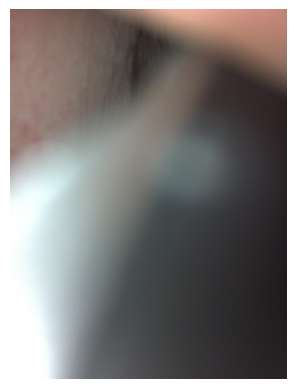

Answer: unsuitable, Answer Type: unanswerable


In [124]:
path = "/kaggle/input/d/lhanhsin/vizwiz/test/test/VizWiz_test_00000010.jpg"
question = "Whats the date?"
predict(question,path)

## IMG 4 - TAKEN BY US

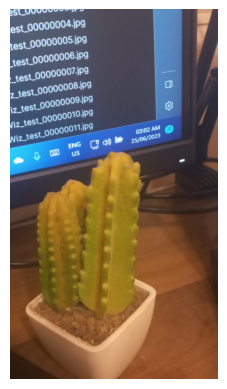

Answer: plant, Answer Type: other


In [128]:
path = "/kaggle/input/encd21/WhatsApp Image 2023-06-25 at 03.02.37.jpg"
question = "What is this?"
predict(question,path)

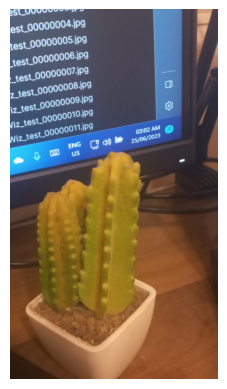

Answer: green, Answer Type: other


In [129]:
path = "/kaggle/input/encd21/WhatsApp Image 2023-06-25 at 03.02.37.jpg"
question = "What is the color?"
predict(question,path)

## IMG 5 - TAKEN BY US

In [130]:
path = "/kaggle/input/encd21/WhatsApp Image 2023-06-25 at 03.05.47.jpg"
question = "What is this?"
predict(question,path)

Answer: computer, Answer Type: other


## IMG 6 - TAKEN BY US

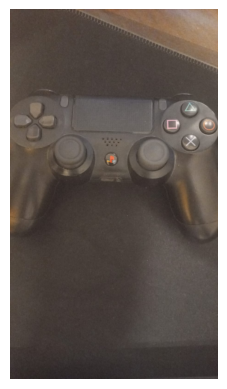

Answer: unanswerable, Answer Type: other


In [131]:
path = "/kaggle/input/encd21/WhatsApp Image 2023-06-25 at 03.09.37.jpg"
question = "What is this?"
predict(question,path)

## IMG 7 - TAKEN BY US

In [132]:
path = "/kaggle/input/encd21/WhatsApp Image 2023-06-25 at 03.12.55.jpg"
question = "What is this?"
predict(question,path)

Answer: unanswerable, Answer Type: other


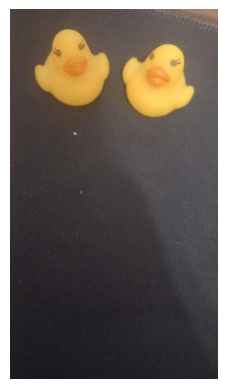

Answer: yellow, Answer Type: other


In [133]:
path = "/kaggle/input/encd21/WhatsApp Image 2023-06-25 at 03.12.55.jpg"
question = "What is the color?"
predict(question,path)

## IMG 8 - DOWNLOADED

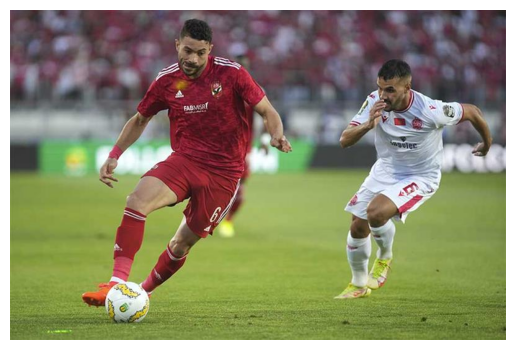

Answer: unanswerable, Answer Type: other


In [134]:
path = "/kaggle/input/encd21/41_2023-638221186302573258-257.jpg"
question = "What is this game?"
predict(question,path)

In [ ]:
path = "/kaggle/input/encd21/41_2023-638221186302573258-257.jpg"
question = "What is this game?"
predict(question,path)

## IMG 9 - TAKEN BY US

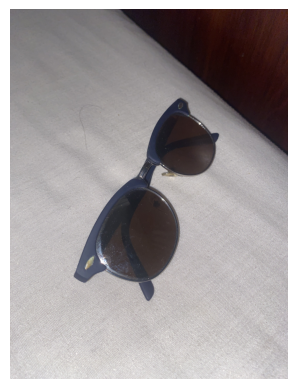

Answer: sunglasses, Answer Type: other


In [135]:
path = "/kaggle/input/encd21/IMG_5420.jpg"
question = "What is this?"
predict(question,path)

## IMG 10 - DOWNLOADED

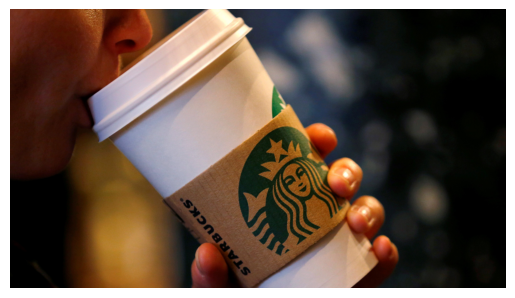

Answer: caffe verona, Answer Type: other


In [136]:
path = "/kaggle/input/encd21/2018-01-25t224358z1006734205rc121b3e0e30rtrmadp3starbucks-results1jpg-1125677-1657560447.jpg"
question = "What kind of coffee is this?"
predict(question,path)

#### HINT CAFFE VERONA IS STARBUCKS BRAND

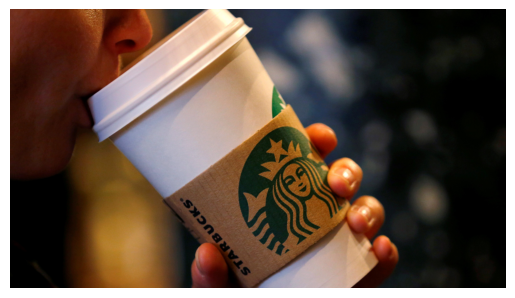

Answer: coffee, Answer Type: other


In [137]:
path = "/kaggle/input/encd21/2018-01-25t224358z1006734205rc121b3e0e30rtrmadp3starbucks-results1jpg-1125677-1657560447.jpg"
question = "What is this?"
predict(question,path)

## IMG 11 - DOWNLOADED

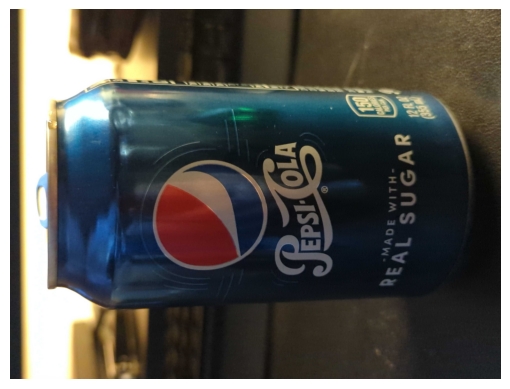

Answer: pepsi, Answer Type: other


In [140]:
path = "/kaggle/input/encd21/front_en.3.full.jpg"
question = "What is this?"
predict(question,path)

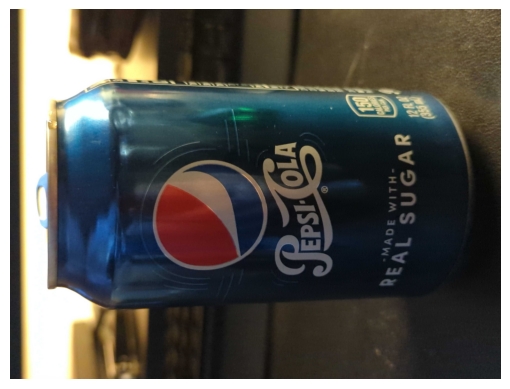

Answer: pepsi, Answer Type: other


In [141]:
path = "/kaggle/input/encd21/front_en.3.full.jpg"
question = "Can you identify this product?"
predict(question,path)

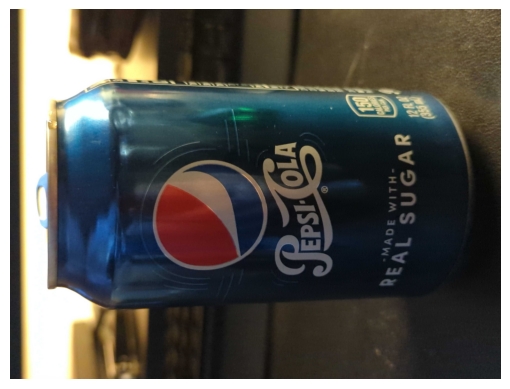

Answer: pepsi, Answer Type: other


In [142]:
path = "/kaggle/input/encd21/front_en.3.full.jpg"
question = "What is the direction of the can top?"
predict(question,path)

## IMG 12 - DOWNLOADED

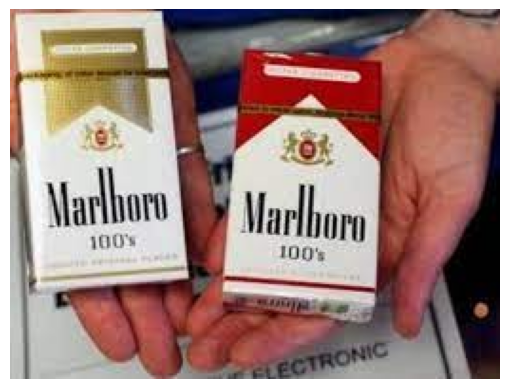

Answer: marlboro, Answer Type: other


In [145]:
path = "/kaggle/input/encd21/download.jpeg"
question = "What kind of cigarettes are these?"
predict(question,path)

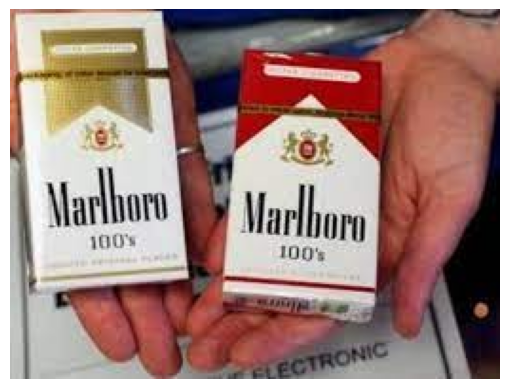

Answer: yes, Answer Type: yes/no


In [146]:
path = "/kaggle/input/encd21/download.jpeg"
question = "Is there a cigrattes?"
predict(question,path)

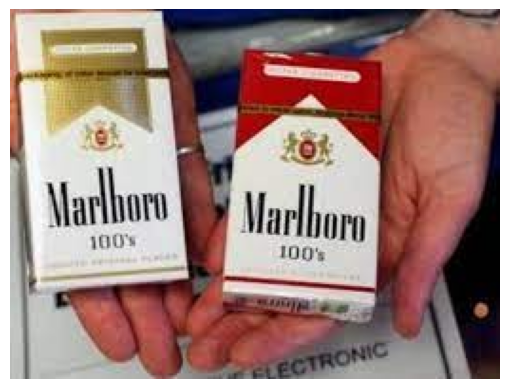

Answer: blue, Answer Type: other


In [149]:
path = "/kaggle/input/encd21/download.jpeg"
question = "What is the color of the rigth box?"
predict(question,path)

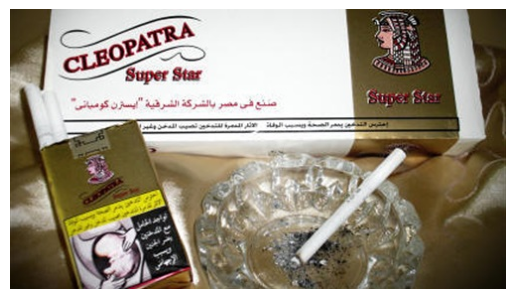

Answer: no, Answer Type: yes/no


In [151]:
path = "/kaggle/input/encd21/634608d9550576354be58785ea8ba9dc.jpg"
question = "Is there a cigrattes?"
predict(question,path)